### Task 1  

Pandas is used to process The fake news corpus. Since content will be used for our models we drop any rows that don't have any content.

In [1]:
import pandas as pd
url = 'https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv'
df = pd.read_csv(url)
print(df.head)

<bound method NDFrame.head of      Unnamed: 0     id                domain        type  \
0             0    141               awm.com  unreliable   
1             1    256     beforeitsnews.com        fake   
2             2    700           cnnnext.com  unreliable   
3             3    768               awm.com  unreliable   
4             4    791  bipartisanreport.com   clickbait   
..          ...    ...                   ...         ...   
245         245  39259     beforeitsnews.com        fake   
246         246  39468     beforeitsnews.com        fake   
247         247  39477       www.newsmax.com         NaN   
248         248  39550       www.newsmax.com         NaN   
249         249  39558       www.newsmax.com         NaN   

                                                   url  \
0    http://awm.com/church-congregation-brings-gift...   
1    http://beforeitsnews.com/awakening-start-here/...   
2    http://www.cnnnext.com/video/18526/never-hike-...   
3    http://awm.c

We've implemented data processing functions to do the following:

    - Clean the text
    - Tokenize the text
    - Remove stopwords
    - Remove word variations with stemming
We use nltk and cleantext because it has built-in support for many of these operations.
We also use collections to import a counter, sklearn to import functions to split the dataset, chain to help with counting and matplotlib for visualizing.

----- Vocabulary Analysis -----
Original vocabulary size: 16673
Vocabulary size after stopword removal: 16445
Reduction rate after stopword removal: 1.37%

----- Stemming Analysis -----
Vocabulary size after stemming: 11031
Reduction rate after stemming: 32.92%

----- Top 10 Words -----
Original sample: [('the', 9487), ('of', 4965), ('to', 4888), ('and', 4697), ('a', 3379), ('in', 3108), ('is', 2317), ('that', 2203), ('<num>', 1570), ('for', 1552)]
Tokenized (stopword-removed) sample: [('<num>', 2192), ('us', 447), ('one', 423), ('people', 368), ('like', 327), ('would', 321), ('trump', 301), ('time', 291), ('also', 276), ('new', 270)]
Stemmed sample: [('<num>', 2192), ('one', 463), ('us', 447), ('like', 406), ('time', 393), ('peopl', 387), ('state', 366), ('trump', 348), ('use', 322), ('would', 321)]

----- Placeholder Token Counts -----
Number of URLs: 243
Number of dates: 104
Number of numerics: 2192


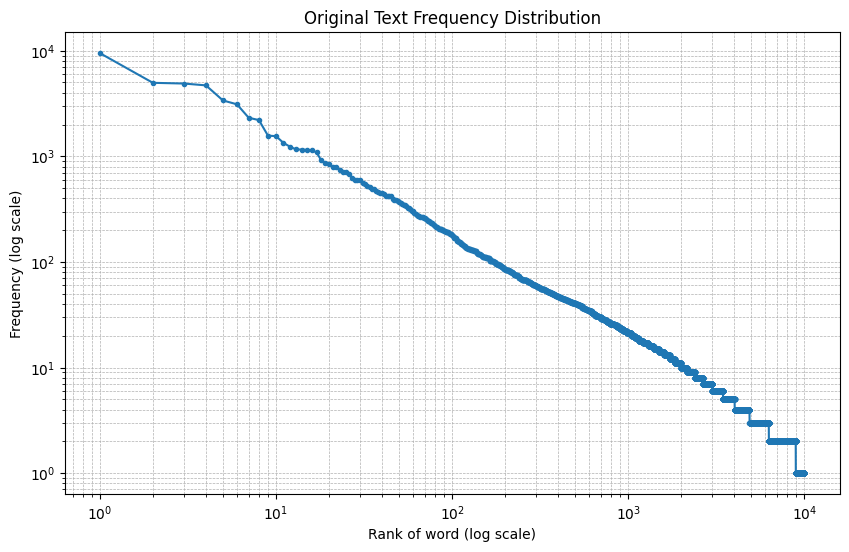

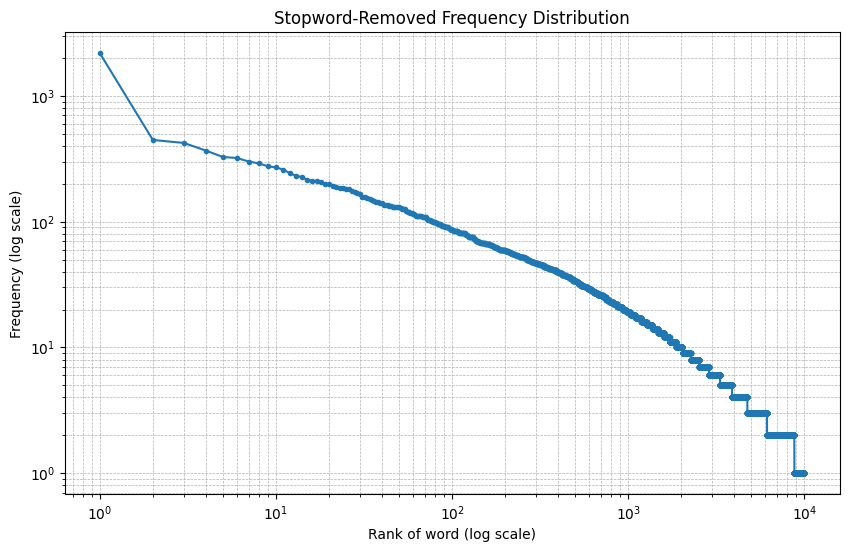

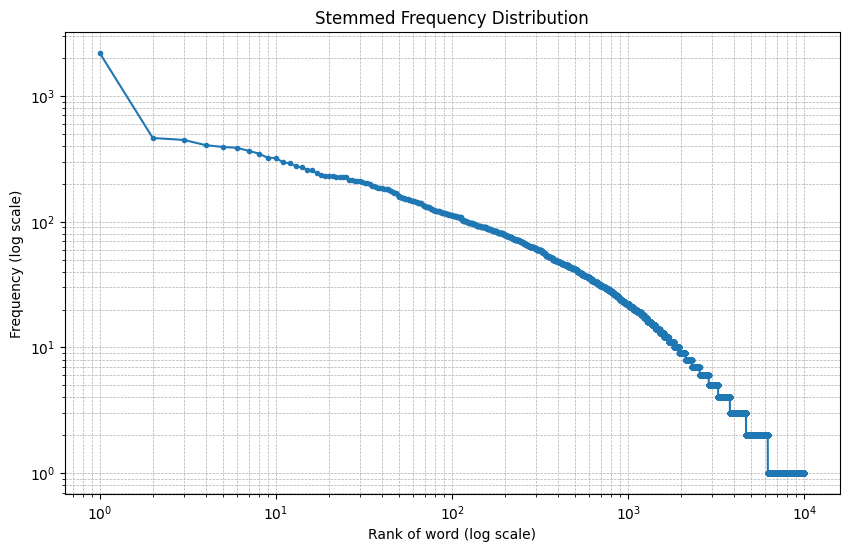


----- DataFrame Summary -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        250 non-null    int64  
 1   id                250 non-null    int64  
 2   domain            250 non-null    object 
 3   type              238 non-null    object 
 4   url               250 non-null    object 
 5   content           250 non-null    object 
 6   scraped_at        250 non-null    object 
 7   inserted_at       250 non-null    object 
 8   updated_at        250 non-null    object 
 9   title             250 non-null    object 
 10  authors           170 non-null    object 
 11  keywords          0 non-null      float64
 12  meta_keywords     250 non-null    object 
 13  meta_description  54 non-null     object 
 14  tags              27 non-null     object 
 15  summary           0 non-null      float64
 16  combined_text

(     Unnamed: 0     id              domain  type  \
 132         132  21862   beforeitsnews.com  fake   
 225         225  36979   beforeitsnews.com  fake   
 238         238  38549     www.newsmax.com   NaN   
 119         119  20071   beforeitsnews.com  fake   
 136         136  22445   beforeitsnews.com  fake   
 ..          ...    ...                 ...   ...   
 106         106  18269   beforeitsnews.com  fake   
 14           14   1920  barenakedislam.com  hate   
 92           92  15564   beforeitsnews.com  fake   
 179         179  27701   beforeitsnews.com  fake   
 102         102  17497   beforeitsnews.com  fake   
 
                                                    url  \
 132  http://beforeitsnews.com/marijuana-debate/2016...   
 225  http://beforeitsnews.com/survival/2017/11/list...   
 238  https://www.newsmax.com/newsfront/david-letter...   
 119  http://beforeitsnews.com/prophecy/2016/04/the-...   
 136  http://beforeitsnews.com/u-s-politics/2016/11/...   
 ..     

In [2]:
import re
import pandas as pd
from collections import Counter
from itertools import chain
from nltk.tokenize import RegexpTokenizer
from cleantext import clean
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


def plot_word_frequency(counter, top_n=10000, title="Word Frequency Distribution"):
    """
    Plots the frequency distribution of the top_n words using a log-log plot.
    """
    # Extract frequencies of the most common words
    freqs = [freq for word, freq in counter.most_common(top_n)]
    
    plt.figure(figsize=(10, 6))
    plt.loglog(range(1, len(freqs) + 1), freqs, marker=".")
    plt.xlabel("Rank of word (log scale)")
    plt.ylabel("Frequency (log scale)")
    plt.title(title)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()


# Regex pattern for tokenization
# <\w+> matches tags (e.g., <num>), [\w]+(?:-[\w]+)? matches words with hyphens
pattern = r'<\w+>|[\w]+(?:-[\w]+)?'
tokenizer = RegexpTokenizer(pattern)

def clean_text(text: str) -> str:
    clean_text = re.sub(
        r'([A-Za-z]+\.?\s[0-9]{1,2}?,\s[0-9]{4})|\b\d{4}-\d{2}-\d{2}\b|\b\d{2}-\d{2}-\d{4}\b', 
        '<DATE>', 
        text
    )
    clean_text = clean(clean_text,
        lower=True,
        no_urls=True, replace_with_url="<URL>",
        no_emails=True, replace_with_email="<EMAIL>",
        no_numbers=True, replace_with_number= r"<NUM>",
        no_currency_symbols=True, replace_with_currency_symbol="<CUR>",
        no_punct=True, replace_with_punct="",
        no_line_breaks=True 
    )
    return clean_text

def tokenize_text(text: str, stop_words: set) -> list:
    """
    Tokenizes the input text using NLTK and removes stopwords.
    """
    tokens = tokenizer.tokenize(text)
    return [token for token in tokens if token not in stop_words]

def stem_tokens(tokens: list) -> list:
    """
    Applies Porter stemming to a list of tokens.
    """
    ps = PorterStemmer()
    return [ps.stem(token) for token in tokens]

def split_dataset(df, train_ratio=0.8, val_ratio=0.1):
    """
    Splits the DataFrame into training, validation, and test sets.
    """
    train_df, temp_df = train_test_split(df, test_size=(1 - train_ratio), random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=val_ratio/(1 - train_ratio), random_state=42)
    return train_df, val_df, test_df

def main(df, text_columns):
    """
    Processes text data by cleaning, tokenizing, and stemming.
    This version handles multiple text columns at once by combining them.
    
    Parameters:
        df (pandas.DataFrame): Input DataFrame.
        text_columns (str or list): Name of the text column or a list of text column names.
    """
    # Ensure text_columns is a list
    if isinstance(text_columns, str):
        text_columns = [text_columns]
    
    # Create a combined text column by joining the specified columns (ignoring any NaNs)
    df['combined_text'] = df[text_columns].apply(lambda row: " ".join(row.dropna().astype(str)), axis=1)
    
    # Define English stopwords set
    stop_words = set(stopwords.words('english'))
    
    # Clean the combined text data
    df['cleaned_text'] = df['combined_text'].apply(clean_text)
    
    # Tokenize the cleaned text and remove stopwords
    df['tokenized_text'] = df['cleaned_text'].apply(lambda x: " ".join(tokenize_text(x, stop_words)))
    
    # Save tokenized text to CSV (the file name reflects that columns were combined)
    df['tokenized_text'].to_csv("combined_tokenized_news_sample.csv", index=False)
    
    # Count word frequencies in the tokenized text
    tokenized_series = df['tokenized_text']
    all_tokens = list(chain.from_iterable(tokenized_series.str.split()))
    token_freq = Counter(all_tokens)
    
    # Count word frequencies in the cleaned (lowercased) text for comparison
    original_tokens = list(chain.from_iterable(df['cleaned_text'].str.split()))
    original_freq = Counter(original_tokens)
    
    # Compute vocabulary sizes and reduction rate after stopword removal
    vocab_original = set(original_tokens)
    vocab_tokenized = set(all_tokens)
    reduction_rate_stopwords = (len(vocab_original) - len(vocab_tokenized)) / len(vocab_original)
    
    print("----- Vocabulary Analysis -----")
    print(f"Original vocabulary size: {len(vocab_original)}")
    print(f"Vocabulary size after stopword removal: {len(vocab_tokenized)}")
    print(f"Reduction rate after stopword removal: {reduction_rate_stopwords:.2%}")
    
    # Apply stemming to the tokenized text
    df['stemmed_text'] = df['tokenized_text'].apply(lambda x: " ".join(stem_tokens(x.split())))
    df['stemmed_text'].to_csv("combined_stemmed_news_sample.csv", index=False)
    
    # Count word frequencies in the stemmed text
    all_stemmed_tokens = list(chain.from_iterable(df['stemmed_text'].str.split()))
    stem_freq = Counter(all_stemmed_tokens)
    
    # Compute vocabulary size and reduction rate after stemming
    vocab_stemmed = set(all_stemmed_tokens)
    reduction_rate_stemming = (len(vocab_tokenized) - len(vocab_stemmed)) / len(vocab_tokenized)
    
    print("\n----- Stemming Analysis -----")
    print(f"Vocabulary size after stemming: {len(vocab_stemmed)}")
    print(f"Reduction rate after stemming: {reduction_rate_stemming:.2%}")
    
    # Print top 10 words for each version of the text
    print("\n----- Top 10 Words -----")
    print(f"Original sample: {original_freq.most_common(10)}")
    print(f"Tokenized (stopword-removed) sample: {token_freq.most_common(10)}")
    print(f"Stemmed sample: {stem_freq.most_common(10)}")
    
    # Count placeholder tokens (note: the clean function lowercases text)
    url_count = df['stemmed_text'].str.count("<url>").sum()
    date_count = df['stemmed_text'].str.count("<date>").sum()
    num_count = df['stemmed_text'].str.count("<num>").sum()
    
    print("\n----- Placeholder Token Counts -----")
    print(f"Number of URLs: {url_count}")
    print(f"Number of dates: {date_count}")
    print(f"Number of numerics: {num_count}")
    
    # Plot frequency distributions
    plot_word_frequency(original_freq, top_n=10000, title="Original Text Frequency Distribution")
    plot_word_frequency(token_freq, top_n=10000, title="Stopword-Removed Frequency Distribution")
    plot_word_frequency(stem_freq, top_n=10000, title="Stemmed Frequency Distribution")
    
    print("\n----- DataFrame Summary -----")
    print(df.info())
    print(df.describe(include="all"))
    
    # Split the DataFrame into training, validation, and test sets
    train_df, val_df, test_df = split_dataset(df)
    print("\nDataset split sizes:")
    print(f"Training set: {len(train_df)} rows")
    print(f"Validation set: {len(val_df)} rows")
    print(f"Test set: {len(test_df)} rows")

    train_df, val_df, test_df = split_dataset(df)
    return train_df, val_df, test_df  # Returner datasættene

# Read the CSV file into a DataFrame and select a subset (for testing)
df = pd.read_csv("/Users/frejaseidler/Desktop/news_sample.csv", encoding="utf-8")
df_sample = df.head(300).copy()  # For a large dataset, consider processing in chunks
main(df_sample, text_columns='content')

### Task 2

We apply our data processing pipeline from task 1 on the 995k FakeNewsCorpus.

Since Pandas is slow on larger datasets we can use modin and ray to optimize pandas and allow for multithreading.

2025-03-21 12:44:10,556	INFO worker.py:1841 -- Started a local Ray instance.
(raylet) Spilled 2324 MiB, 14 objects, write throughput 236 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(raylet) Spilled 5586 MiB, 24 objects, write throughput 390 MiB/s.


----- Vocabulary Analysis -----
Original vocabulary size: 17842
Vocabulary size after stopword removal: 17621
Reduction rate after stopword removal: 1.24%

----- Stemming Analysis -----
Vocabulary size after stemming: 12473
Reduction rate after stemming: 29.22%

----- Top 10 Words -----
Original sample: [('the', 9319), ('of', 4570), ('to', 4426), ('and', 3930), ('a', 3520), ('in', 3019), ('<num>', 2383), ('that', 1907), ('is', 1628), ('for', 1497)]
Tokenized (stopword-removed) sample: [('<num>', 3915), ('said', 493), ('one', 378), ('new', 342), ('people', 334), ('us', 324), ('would', 309), ('<cur>', 244), ('also', 236), ('mr', 235)]
Stemmed sample: [('<num>', 3915), ('said', 493), ('one', 404), ('state', 384), ('peopl', 353), ('new', 342), ('us', 324), ('would', 309), ('time', 307), ('year', 282)]

----- Placeholder Token Counts -----
Number of URLs: 83
Number of dates: 130
Number of numerics: 3915


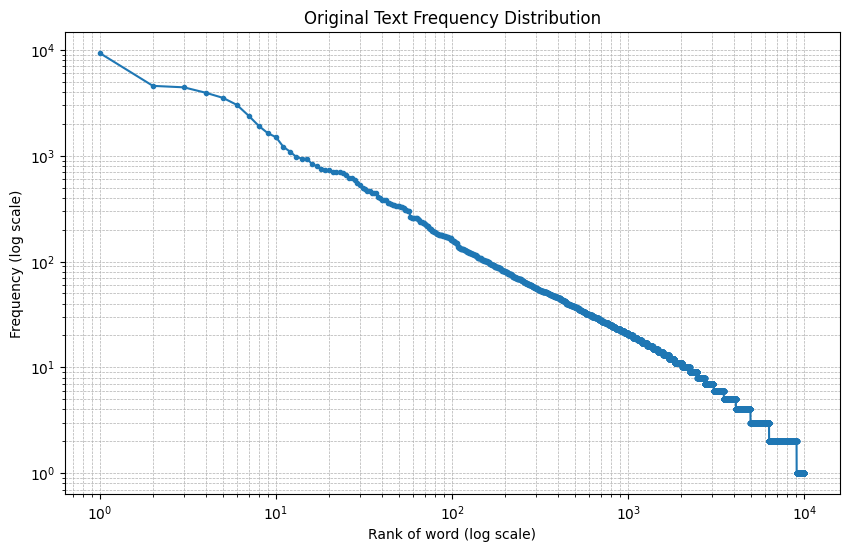

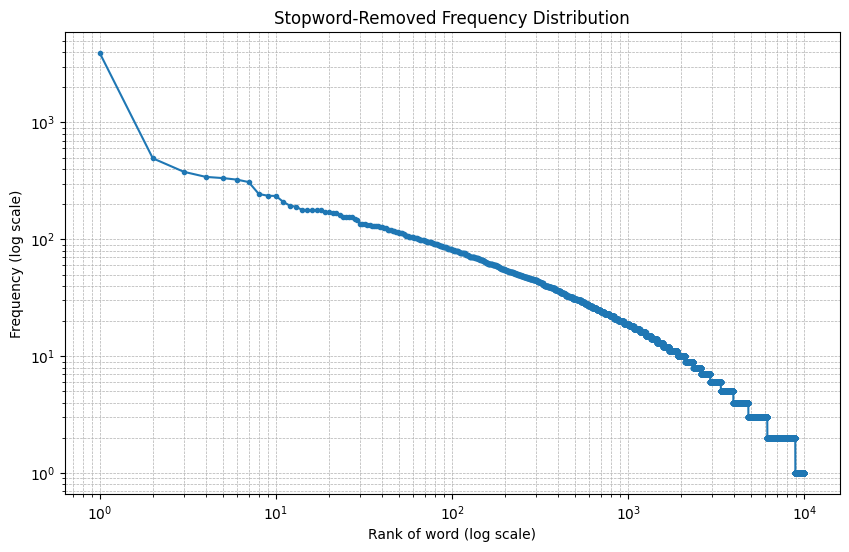

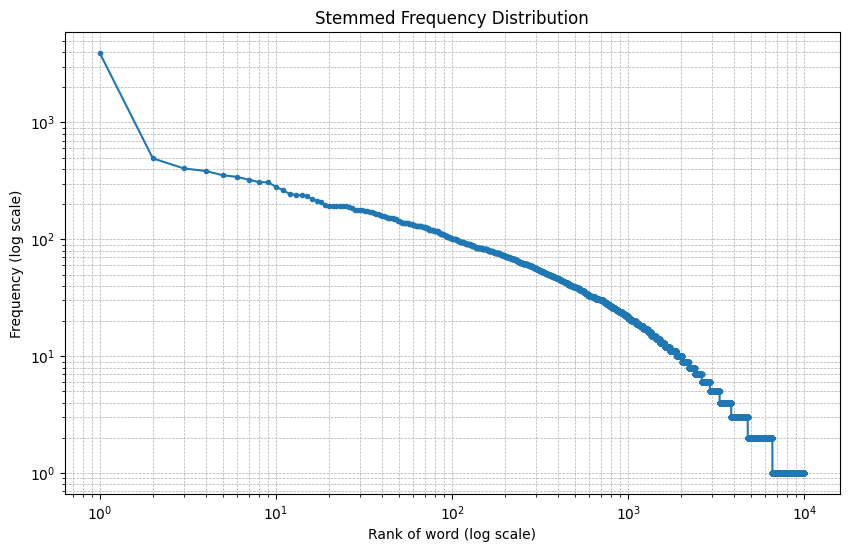


----- DataFrame Summary -----
<class 'modin.pandas.dataframe.DataFrame'>
Index: 300 entries, 0 to 315
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   domain          300 non-null    object
 1   type            300 non-null    object
 2   content         300 non-null    object
 3   title           300 non-null    object
 4   combined_text   300 non-null    object
 5   cleaned_text    300 non-null    object
 6   tokenized_text  300 non-null    object
 7   stemmed_text    300 non-null    object
dtypes: object(8)
memory usage: 21.1+ KB
None
             domain      type  \
count           300       300   
unique           97        12   
top     nytimes.com  reliable   
freq             62        76   

                                                  content               title  \
count                                                 300                 300   
unique                                             

(                    domain        type  \
 246                awm.com  unreliable   
 62      abovetopsecret.com  conspiracy   
 6             dailykos.com   political   
 199        libertynews.com  unreliable   
 187            nytimes.com    reliable   
 ..                     ...         ...   
 202            nytimes.com    reliable   
 75           express.co.uk       rumor   
 116           opednews.com     unknown   
 285            nytimes.com    reliable   
 112  blackagendareport.com  unreliable   
 
                                                content  \
 246  First-grade teacher Bret Turner was just think...   
 62   These pictures I believe surfaced on the web a...   
 6    Disclaimer. This is general information on a l...   
 199  The Hill is reporting on a request made to the...   
 187  When George W. Bush was running for president,...   
 ..                                                 ...   
 202  Most people do far more than just eat at the d...   
 75   He h

In [3]:
import modin.config as modin_config
import modin.pandas as pd
modin_config.Engine.put('ray')

# only read the columns we need
df = pd.read_csv("/Users/frejaseidler/Desktop/995,000_rows.csv", 
                 usecols=['content', 'type', 'title', 'domain'], 
                 engine='c', 
                 dtype = str)
df = df.dropna(subset=['content', 'type', 'title'])
main(df.head(300).copy(), text_columns=df.columns)


## Part 2  
### Task 1  

To build a baseline model for Fake News classification, we implemented a **logistic regression model** using a vocabulary of the 10,000 most frequently occurring words.  

We used `CountVectorizer` to transform the text data into numerical features. The model was trained on the dataset to distinguish between **reliable** and **fake** news articles.



In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

def categorize_type(df):
    """ Categorize types in omitted, fake, reliable """
    omitted = {'hate', 'bias', 'satire', 'unreliable', 'state'}
    fake = {'fake', 'junksci', 'conspiracy'}
    reliable = {'reliable', 'political', 'clickbait'}

    df_categorized = df[~df['type'].isin(omitted)].copy()
    df_categorized['type'] = df_categorized['type'].map(lambda x: 'fake' if x in fake else ('reliable' if x in reliable else None))
    df_categorized = df_categorized.dropna(subset=['type'])

    return df_categorized

# Rens FakeNewsCorpus datasættet 
df = categorize_type(df)

# Load articles_clara.csv 
scraped_df = pd.read_csv("/Users/frejaseidler/Desktop/GDS_Eksamen /articles_clara.csv", encoding="utf-8")

print(scraped_df.columns)
# Sikre at nødvendige kolonner findes i `clara_df`
if 'text' in scraped_df.columns:
    scraped_df = scraped_df.rename(columns={'text': 'content'})
    scraped_df['type'] = 'reliable'  # Marker artikler i Articels_clara som pålidelige
    scraped_df = scraped_df[['content', 'type']]
else:
    raise ValueError("Fejl: Kolonnen 'text' mangler i articles_clara.csv")

print("Type of df:", type(df))  # Ensure df is a DataFrame
print("Type of scraped_df:", type(scraped_df))  # Ensure scraped_df is a DataFrame

# Convert Modin DataFrame to Pandas before concatenation
df = df._to_pandas() 

# Sammenlæg de to datasæt
combined_train_df = pd.concat([df, scraped_df], ignore_index=True)

# Opdel data i træning (80%), validering (10%) og test (10%)
train_df, val_df, test_df = np.split(combined_train_df.sample(frac=1, random_state=42), 
                                     [int(0.8*len(combined_train_df)), int(0.9*len(combined_train_df))])

# Brug CountVectorizer til at transformere tekst til numeriske features
vectorizer = CountVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(train_df['content'])
X_test = vectorizer.transform(test_df['content'])

# Konverter labels til binære værdier (1 = Fake, 0 = Reliable)
y_train = np.array([1 if label == "fake" else 0 for label in train_df['type']])
y_test = np.array([1 if label == "fake" else 0 for label in test_df['type']])

# Træn en simpel logistisk regressionsmodel
clf = LogisticRegression(max_iter=500, solver='saga')
clf.fit(X_train, y_train)

# Lav forudsigelser på testdata
y_pred = clf.predict(X_test)

# Evaluer modellen
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Model performance after integrating Articles_Clara dataset:")
print(f"Accuracy: {accuracy:.2%}")
print(f"F1 Score: {f1:.2%}")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Extract TP, TN, FP, FN
tn, fp, fn, tp = cm.ravel()

# Udskriv resultater
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

Index(['url', 'title', 'summary', 'author', 'headline', 'date', 'text'], dtype='object')
Type of df: <class 'modin.pandas.dataframe.DataFrame'>
Type of scraped_df: <class 'pandas.core.frame.DataFrame'>


(raylet) Spilled 9260 MiB, 80 objects, write throughput 449 MiB/s.


Model performance after integrating Articles_Clara dataset:
Accuracy: 89.09%
F1 Score: 82.54%

Confusion Matrix:
[[41097  3022]
 [ 4056 16725]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     44119
           1       0.85      0.80      0.83     20781

    accuracy                           0.89     64900
   macro avg       0.88      0.87      0.87     64900
weighted avg       0.89      0.89      0.89     64900

True Positives (TP): 16725
True Negatives (TN): 41097
False Positives (FP): 3022
False Negatives (FN): 4056


### Task 2
Meta data tilføjes 

## Part 3

In [5]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

# Use TF-IDF Vectorizer to transform text into a vocabulary of the 10,000 most frequent words
vectorizer = TfidfVectorizer(max_features=2000)

# Convert text content into numerical feature matrices
X_train_tfidf = vectorizer.fit_transform(train_df['content'])
X_test_tfidf = vectorizer.transform(test_df['content'])

# Convert labels to binary values (1 = Fake, 0 = Reliable)
y_train_tfidf = np.array([1 if label == "fake" else 0 for label in train_df['type']])
y_test_tfidf = np.array([1 if label == "fake" else 0 for label in test_df['type']])

model = LinearSVC( C=1.0, random_state = 0)
model.fit(X_train_tfidf, y_train_tfidf)

y=model.predict(X_test_tfidf)
y2=model.predict(X_train_tfidf)

score =accuracy_score(y, y_test_tfidf)
print(score)
score2 =accuracy_score(y2, y_train_tfidf )
print(score2)
#%%
# import matplotlib.pyplot as plt
# color = ['black' if c == 0 else 'lightgrey' for c in y]
# plt.scatter(X_train[:,0], X_train[:,1], c=color)

# # Create the hyperplane
# w = model.coef_[0]
# a = -w[0] / w[1]
# xx = np.linspace(-2.5, 2.5)
# yy = a * xx - (model.intercept_[0]) / w[1]

# # Plot the hyperplane
# plt.plot(xx, yy)
# plt.axis("off"), plt.show();
